In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import scipy

In [3]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/20190522_tnr550_cav1/Bestparams/20190522_tnr550_cav1_plus20mins_crankup_betweenframes/'
protein="TNR" #TNR,Agg,WFA,HABP

In [31]:
results = {"filename":[],
          "exp condition":[],
          "ecmchannelno":[],
          "endosomechannelno":[]
          }
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    #if "_analyse" in str(filelist[i]):
        #if "DiO" in str(filelist[i]):
            #if ("Focus" in str(filelist[i]))==False:
                #if (protein in str(filelist[i]))==True:
                    if filelist[i].endswith(".tif"): 
                        if str(filelist[i][:-12]) not in str(results["filename"]):
                            results["filename"].append(filelist[i][:-12])
                            results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                            channeldir="/".join(filelist[i][:-12].split("/")[:-2])
                            exec(open(channeldir+"/channels.txt").read())
                            results["ecmchannelno"].append(ecmchannelno)
                            results["endosomechannelno"].append(endosomechannelno)
                                        

## Loading a random image

In [33]:
ecm_image_name=results["filename"][2]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"

ecm_image=pims.open(ecm_image_name)[2]

IndexError: list index out of range

Image name: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes_Series0_z
Experimental condition: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


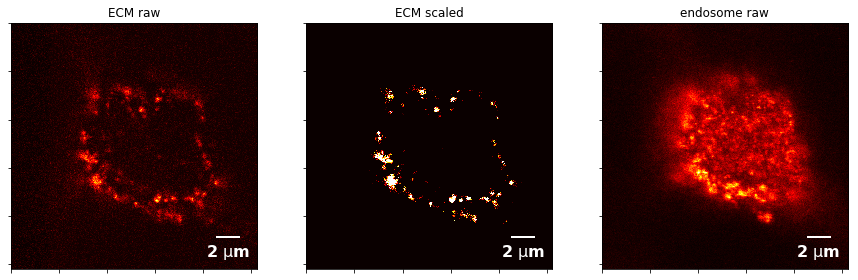

In [5]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
endosome_channel_no=results["endosomechannelno"][randomno]
#synapse_channel_no=results["synapsechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
endosome_image_name=results["filename"][randomno]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"
#synapse_image_name=results["filename"][randomno]+"0_ch"+str(synapse_channel_no-1)+"_t0.tif"

print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
endosome_image=pims.open(endosome_image_name)[0]
#synapse_image=pims.open(synapse_image_name)[0]
   
figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
figure.add_subplot(132)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM scaled')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

figure.add_subplot(133)
plt.imshow(endosome_image,interpolation='none',cmap='hot')
plt.title('endosome raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

## Find spots

### Random processed image

### 2x2 binning

In [6]:
#backup
ecm_image_raw=deepcopy(ecm_image)
endosome_image_raw=deepcopy(endosome_image)

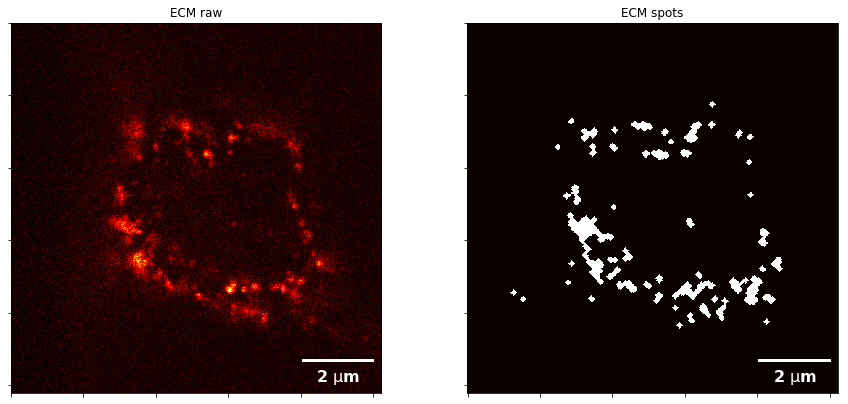

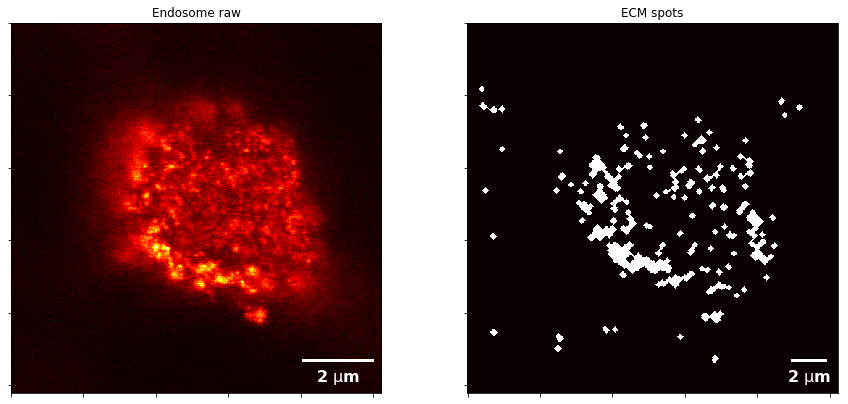

In [7]:
'''#2x2 binning --> new pixel size = 40nm
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)
ecm_image=np.asarray(ecm_image_raw)
ecm_image=rebin(ecm_image,[512,512])
endosome_image=rebin(endosome_image_raw,[512,512])
synapse_image=rebin(synapse_image_raw,[512,512])'''

#bandpass
lowpass = ndi.gaussian_filter(ecm_image, 3)
ecm_image = ecm_image - lowpass
lowpass = ndi.gaussian_filter(endosome_image, 3)
endosome_image = endosome_image - lowpass


#binarize to find spots
ecm_image[ecm_image<1]=0
ecm_image[ecm_image>1]=1
endosome_image[endosome_image<1]=0
endosome_image[endosome_image>1]=1


#some morphological operations
#watershed attempt
'''from skimage.morphology import watershed
from skimage.feature import peak_local_max
distance = ndi.distance_transform_edt(ecm_image_high)
local_maxi = peak_local_max(distance, indices=False, 
                            footprint=np.ones((5, 5)), labels=ecm_image_high)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=ecm_image_high)'''

ecm_image=ndi.binary_opening(ecm_image,iterations=4)
ecm_image=ndi.binary_closing(ecm_image,iterations=4)
endosome_image=ndi.binary_opening(endosome_image,iterations=4)
endosome_image=ndi.binary_closing(endosome_image,iterations=4)
#synapse_image=ndi.binary_opening(synapse_image,iterations=2)
#synapse_image=ndi.binary_closing(synapse_image,iterations=2)

figure=plt.figure(figsize=(15,15))
figure.add_subplot(221)
plt.imshow(ecm_image_raw,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)

figure.add_subplot(222)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM spots')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)

figure=plt.figure(figsize=(15,15))
figure.add_subplot(223)
plt.imshow(endosome_image_raw,interpolation='none',cmap='hot')
plt.title('Endosome raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)

figure.add_subplot(224)
plt.imshow(endosome_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM spots')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)



## Batch analysis

### Find the spots in all images

In [8]:
## make spots dictionaries
ecm_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest endosome centroid":[],
                  
                 "distance to nearest endosome centroid [nms]":[]
                  }
endosome_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest ecm centroid":[],
                  
                       
                       "distance to nearest ecm centroid [nms]":[]}

for image in range(0,len(results["filename"])):
    print('Calculating image no ' + str(image+1) + ' out of' + str(len(results["filename"])))
    #read images
    ecm_channel_no=results["ecmchannelno"][image]
    endosome_channel_no=results["endosomechannelno"][image]
    #synapse_channel_no=results["synapsechannelno"][image]

    ecm_image_name=results["filename"][image]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
    endosome_image_name=results["filename"][image]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"
    #synapse_image_name=results["filename"][image]+"0_ch"+str(synapse_channel_no-1)+"_t0.tif"

    print("Image name:",results["filename"][image].split('/')[-1])
    print("Experimental condition:",results["exp condition"][image])
    ecm_image=pims.open(ecm_image_name)[0]
    endosome_image=pims.open(endosome_image_name)[0]
    #synapse_image=pims.open(synapse_image_name)[0]
    
    #backup
    ecm_image_raw=deepcopy(ecm_image)
    #synapse_image_raw=deepcopy(synapse_image)
    endosome_image_raw=deepcopy(endosome_image)
    
    #2x2 binning --> new pixel size = 40nm
    ecm_image=np.asarray(ecm_image_raw)
    #ecm_image=rebin(ecm_image,[512,512])
    #endosome_image=rebin(endosome_image_raw,[512,512])
    #synapse_image=rebin(synapse_image_raw,[512,512])

    #bandpass
    lowpass = ndi.gaussian_filter(ecm_image, 3)
    ecm_image = ecm_image - lowpass
    lowpass = ndi.gaussian_filter(endosome_image, 3)
    endosome_image = endosome_image - lowpass
    #lowpass = ndi.gaussian_filter(synapse_image, 3)
    #synapse_image = synapse_image - lowpass

    #binarize to find spots
    ecm_image[ecm_image<1]=0
    ecm_image[ecm_image>1]=1
    endosome_image[endosome_image<1]=0
    endosome_image[endosome_image>1]=1
    #synapse_image[synapse_image<18]=0
    #synapse_image[synapse_image>18]=1
    
    #morphological operations
    ecm_image=ndi.binary_opening(ecm_image,iterations=4)
    ecm_image=ndi.binary_closing(ecm_image,iterations=4)
    endosome_image=ndi.binary_opening(endosome_image,iterations=4)
    endosome_image=ndi.binary_closing(endosome_image,iterations=4)
    #synapse_image=ndi.binary_opening(synapse_image,iterations=2)
    #synapse_image=ndi.binary_closing(synapse_image,iterations=2)
    
    labeled_ecm=label(ecm_image)
    labeled_endosome=label(endosome_image)
    #labeled_synapse=label(synapse_image)

    regionprops_ecm=regionprops(labeled_ecm)
    regionprops_endosome=regionprops(labeled_endosome)
    #regionprops_synapse=regionprops(labeled_synapse)

    for i in range(0,len(regionprops_ecm)):
        ecm_spots_results["filename"].append(results["filename"][image])
        ecm_spots_results["exp condition"].append(results["exp condition"][image])
        ecm_spots_results["spotno"].append(i)
        ecm_spots_results["centroid"].append(regionprops_ecm[i]['centroid'])
        ecm_spots_results["size"].append(regionprops_ecm[i]['area'])
    for i in range(0,len(regionprops_endosome)):
        endosome_spots_results["filename"].append(results["filename"][image])
        endosome_spots_results["exp condition"].append(results["exp condition"][image])
        endosome_spots_results["spotno"].append(i)
        endosome_spots_results["centroid"].append(regionprops_endosome[i]['centroid'])
        endosome_spots_results["size"].append(regionprops_endosome[i]['area'])
    

Calculating image no 1 out of10
Image name: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes_Series9_z
Experimental condition: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 2 out of10
Image name: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes_Series8_z
Experimental condition: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 3 out of10
Image name: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes_Series7_z
Experimental condition: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 4 out of10
Image name: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes_Series6_z
Experimental condition: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 5 out of10
Image name: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes_Series5_z
Experimental condition: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 6 out of10
Image name: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes_Series4_z
Experimental condition: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 7 out of10
Image name: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes_Series3_z
Experimental condition: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 8 out of10
Image name: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes_Series2_z
Experimental condition: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 9 out of10
Image name: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes_Series1_z
Experimental condition: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 10 out of10
Image name: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes_Series0_z
Experimental condition: 20190522_tnr550_cav1_plus20mins_crankup_betweenframes


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


### Find the min distances between spots

In [9]:
for i in range(0,len(ecm_spots_results["filename"])):
    print(str(i+1)+' out of ' + str(len(ecm_spots_results["filename"])))
    ecm_spots_results["distance to nearest endosome centroid"].append(
        scipy.spatial.distance.cdist([ecm_spots_results["centroid"][i]],
                                     endosome_spots_results["centroid"],'euclidean').min())
    
                                     
    ecm_spots_results["distance to nearest endosome centroid [nms]"].append(
        scipy.spatial.distance.cdist([ecm_spots_results["centroid"][i]],
                                     endosome_spots_results["centroid"],'euclidean').min()*40.6)
    
for i in range(0,len(endosome_spots_results["filename"])):
    print(str(i+1)+' out of ' + str(len(endosome_spots_results["filename"])))
    endosome_spots_results["distance to nearest ecm centroid"].append(
        scipy.spatial.distance.cdist([endosome_spots_results["centroid"][i]],
                                     ecm_spots_results["centroid"],'euclidean').min())
    
                                     
    endosome_spots_results["distance to nearest ecm centroid [nms]"].append(
        scipy.spatial.distance.cdist([endosome_spots_results["centroid"][i]],
                                     ecm_spots_results["centroid"],'euclidean').min()*40.6)


1 out of 362
2 out of 362
3 out of 362
4 out of 362
5 out of 362
6 out of 362
7 out of 362
8 out of 362
9 out of 362
10 out of 362
11 out of 362
12 out of 362
13 out of 362
14 out of 362
15 out of 362
16 out of 362
17 out of 362
18 out of 362
19 out of 362
20 out of 362
21 out of 362
22 out of 362
23 out of 362
24 out of 362
25 out of 362
26 out of 362
27 out of 362
28 out of 362
29 out of 362
30 out of 362
31 out of 362
32 out of 362
33 out of 362
34 out of 362
35 out of 362
36 out of 362
37 out of 362
38 out of 362
39 out of 362
40 out of 362
41 out of 362
42 out of 362
43 out of 362
44 out of 362
45 out of 362
46 out of 362
47 out of 362
48 out of 362
49 out of 362
50 out of 362
51 out of 362
52 out of 362
53 out of 362
54 out of 362
55 out of 362
56 out of 362
57 out of 362
58 out of 362
59 out of 362
60 out of 362
61 out of 362
62 out of 362
63 out of 362
64 out of 362
65 out of 362
66 out of 362
67 out of 362
68 out of 362
69 out of 362
70 out of 362
71 out of 362
72 out of 362
7

304 out of 841
305 out of 841
306 out of 841
307 out of 841
308 out of 841
309 out of 841
310 out of 841
311 out of 841
312 out of 841
313 out of 841
314 out of 841
315 out of 841
316 out of 841
317 out of 841
318 out of 841
319 out of 841
320 out of 841
321 out of 841
322 out of 841
323 out of 841
324 out of 841
325 out of 841
326 out of 841
327 out of 841
328 out of 841
329 out of 841
330 out of 841
331 out of 841
332 out of 841
333 out of 841
334 out of 841
335 out of 841
336 out of 841
337 out of 841
338 out of 841
339 out of 841
340 out of 841
341 out of 841
342 out of 841
343 out of 841
344 out of 841
345 out of 841
346 out of 841
347 out of 841
348 out of 841
349 out of 841
350 out of 841
351 out of 841
352 out of 841
353 out of 841
354 out of 841
355 out of 841
356 out of 841
357 out of 841
358 out of 841
359 out of 841
360 out of 841
361 out of 841
362 out of 841
363 out of 841
364 out of 841
365 out of 841
366 out of 841
367 out of 841
368 out of 841
369 out of 841
370 out of

## Plots

In [10]:
df_ecm=pd.DataFrame(ecm_spots_results)
df_endosome=pd.DataFrame(endosome_spots_results)

### Backup

In [11]:
#os.mkdir(expdir+'results/')
df_ecm.to_csv(path_or_buf=expdir+'results/results_'+str(protein)+'_ecm.csv')
df_endosome.to_csv(path_or_buf=expdir+'results/results_'+str(protein)+'_endosome.csv')
#df_synapses.to_csv(path_or_buf=expdir+'results/results_'+str(protein)+'_synapses.csv')

In [12]:
df_ecm=pd.read_csv(expdir+'results/results_'+str(protein)+'.csv')

FileNotFoundError: [Errno 2] File b'/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/20190522_tnr550_cav1/Bestparams/20190522_tnr550_cav1_plus20mins_crankup_betweenframes/results/results_TNR.csv' does not exist: b'/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/20190522_tnr550_cav1/Bestparams/20190522_tnr550_cav1_plus20mins_crankup_betweenframes/results/results_TNR.csv'

Text(0.5, 0, 'Distance (nms)')

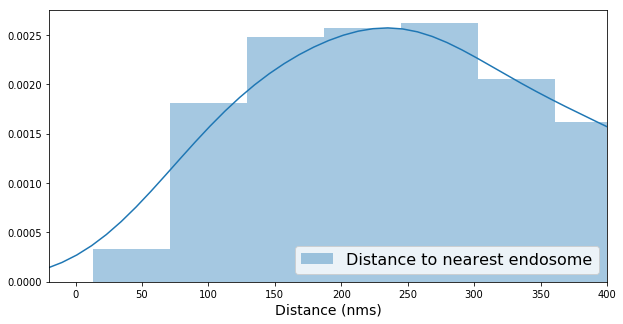

In [13]:
fig=plt.figure(figsize=(10,5))
g=sns.distplot(df_ecm["distance to nearest endosome centroid [nms]"],label="Distance to nearest endosome")
#g=sns.kdeplot(df_endosome["distance to nearest ecm centroid [nms]"],shade=True)
#g=sns.distplot(df_ecm["distance to nearest synapse centroid [nms]"],label="Distance to nearest synapse")
g.set_xticks(np.linspace(0,500,11))
g.set_xlim([-20,400])
plt.legend(fontsize=16)
g.set_xlabel('Distance (nms)',fontsize=14)


In [14]:
df_ecm["exp condition"].unique()

array(['20190522_tnr550_cav1_plus20mins_crankup_betweenframes'],
      dtype=object)

In [16]:
df_ecm['Protein']='None'
df_ecm['Treatment']='None'
df_ecm.loc[df_ecm['exp condition'].str.contains('cav'), 'Protein'] = 'Caveolin 1'
df_ecm.loc[df_ecm['exp condition'].str.contains('Rab5'), 'Protein'] = 'Rab5'
df_ecm.loc[df_ecm['exp condition'].str.contains('Rab7'), 'Protein'] = 'Rab7'
df_ecm.loc[df_ecm['exp condition'].str.contains('Ctrl'), 'Treatment'] = 'Unblocked Control'
df_ecm.loc[df_ecm['exp condition'].str.contains('Blk'), 'Treatment'] = 'Blocked'
df_endosome['Protein']='None'
df_endosome['Treatment']='None'
df_endosome.loc[df_endosome['exp condition'].str.contains('cav'), 'Protein'] = 'Caveolin 1'
df_endosome.loc[df_endosome['exp condition'].str.contains('Rab5'), 'Protein'] = 'Rab5'
df_endosome.loc[df_endosome['exp condition'].str.contains('Rab7'), 'Protein'] = 'Rab7'
df_endosome.loc[df_endosome['exp condition'].str.contains('Ctrl'), 'Treatment'] = 'Unblocked Control'
df_endosome.loc[df_endosome['exp condition'].str.contains('Blk'), 'Treatment'] = 'Blocked'


In [17]:
df_ecm['Distance to endosome']='>50nm'
df_ecm.loc[df_ecm["distance to nearest endosome centroid [nms]"]<50,'Distance to endosome']='<50nm'


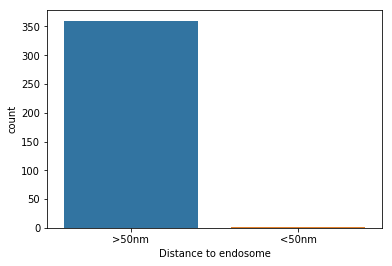

In [18]:
sns.countplot(x="Distance to endosome", data=df_ecm)

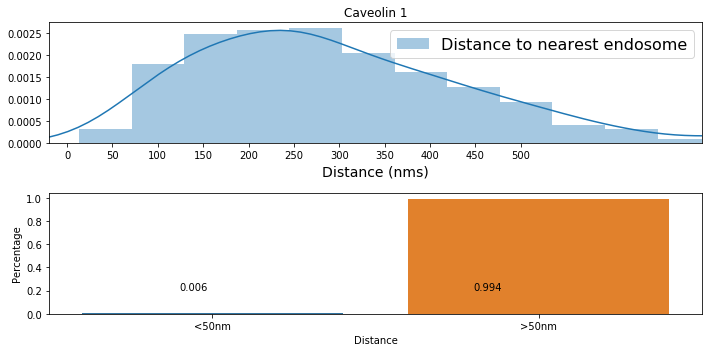

In [24]:
for protein in df_ecm["Protein"].unique():
    #df2plot=df_ecm[(df_ecm["Treatment"]=="Unblocked Control")&(df_ecm["Protein"]==protein)]
    df2plot=df_ecm[(df_ecm["Protein"]==protein)]
    fig=plt.figure(figsize=(10,5))
    fig.add_subplot(211)
    g=sns.distplot(df2plot["distance to nearest endosome centroid [nms]"],label="Distance to nearest endosome")
    g.set_xticks(np.linspace(0,500,11))
    g.set_xlim([-20,700])
    plt.legend(fontsize=16)
    g.set_xlabel('Distance (nms)',fontsize=14)
    plt.title(protein)
    
    fig.add_subplot(212)
    dfcount=df2plot.groupby("Distance to endosome").count()
    smallerthan=dfcount["filename"].unique()[0]
    biggerthan=dfcount["filename"].unique()[1]
    propsmaller=smallerthan/(smallerthan+biggerthan)
    propbigger=biggerthan/(smallerthan+biggerthan)
    dfprops={'Distance':['<50nm','>50nm'],'Percentage':[propsmaller,propbigger]}
    dfprops=pd.DataFrame(dfprops)
    sns.barplot(x="Distance",y="Percentage",data=dfprops)
    plt.text(x=-0.1,y=0.2,s=np.round(propsmaller,3))
    plt.text(x=0.8,y=0.2,s=np.round(propbigger,3))
    
    
    fig.tight_layout()